In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import adjusted_mutual_info_score as AMI
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['figure.figsize'] = (12,12)
import seaborn as sns

sc.settings.verbosity =0


import os
compute = True

import numpy as np
import pandas as pd
from scipy.sparse.csgraph import connected_components

    
def binary_LISI(neigh, metadata):
    """
    Compute a binary version of the Local Inverse Simpson Index (LISI).

    :param neigh: A pynndescent object with the 'indices' attribute having shape (n_cells, n_neighbors)
    :param metadata: An array of shape (n_cells,) containing metadata labels for each cell
    :return: A numpy array of shape (n_cells,) with the binary LISI scores
    """
    n_cells = neigh.indices.shape[0]
    binary_lisi_scores = np.zeros(n_cells)

    for i in range(n_cells):
        center_label = metadata[i]
        neighbor_indices = neigh.indices[i]
        neighbor_labels = metadata[neighbor_indices]

        # Count how many neighbors have the same label as the center cell
        same_label_count = np.sum(neighbor_labels == center_label)
        
        # Compute the proportion of same label in the neighborhood
        binary_lisi_scores[i] = same_label_count / len(neighbor_indices)

    return binary_lisi_scores

def result_exists(mod, i, ann, n_size, ct):
    ct_sanitized = ct.replace('/', '_')  # Sanitize cell type name for use in filename
    filename = f'CLISI_csv_PARTIAL/scIB_{mod}_{i}_{ann}_BINARY_{n_size}_{ct_sanitized}.csv'
    return os.path.exists(filename), filename

def save_binary_lisi_scores(binary_lisi_scores, filename, valid_indices):
    temp_df = pd.DataFrame(binary_lisi_scores, index=valid_indices, columns=['binary_LISI'])
    print(temp_df.shape)

    temp_df.to_csv(filename)



In [24]:
l1_colors = {
'ATL': '#1f77b4',
  'PT_VCAM1': '#c5b0d5',
 'CNT': '#ff7f0e',
 'DCT': '#279e68',
  'DCT1': '#279e68',
 'DCT2': '#ffb500',
 'DTL': '#d62728',
 'EC': '#aa40fc',
 'ENDO': '#aa40fc',
 'FIB': '#8c564b',
 'IC': '#e377c2',
 'ICA': '#e377c2',
 'ICB': '#7b4f4b',
 'IMM': '#b5bd61',
 'LEUK': '#b5bd61',
 'NEU': '#17becf',
 'PC': '#aec7e8',
 'PEC': '#17becf',
 'POD': '#98df8a',
 'PODO': '#98df8a',
'PT': '#ff9896',
 'PapE': '#c5b0d5',
 'TAL': '#c49c94',
'MES': '#f7b6d2',
 'VSM/P': '#f7b6d2','Unclassified':'#d3d3d3'}

In [25]:
l3_colors = {
'ATL': '#ffff00',
 'B': '#1ce6ff',
 'C-TAL': '#ff34ff',
 'PC': '#aec7e8',
 'CCD-IC-A': '#ff4a46',
 'CCD-PC': '#008941',
 'CNT': '#006fa6',
 'CNT-IC-A': '#a30059',
 'CNT-PC': '#ffdbe5',
 'DCT1': '#7a4900',
 'DCT2': '#0000a6',
 'DTL': '#63ffac',
 'EC-AEA': '#b79762',
 'EC-AVR': '#004d43',
 'EC-DVR': '#8fb0ff',
 'EC-GC': '#997d87',
 'EC-LYM': '#5a0007',
 'EC-PTC': '#809693',
 'FIB': '#6a3a4c',
 'IC-B': '#1b4400',
 'IMCD': '#4fc601',
 'M-FIB': '#3b5dff',
 'M-TAL': '#4a3b53',
 'MAC-M2': '#ff2f80',
 'MAST': '#61615a',
 'MC': '#ba0900',
 'MD': '#6b7900',
 'MDC': '#00c2a0',
 'MYOF': '#ffaa92',
 'N': '#ff90c9',
 'NEU': '#b903aa',
 'NKC/T': '#d16100',
 'OMCD-IC-A': '#ddefff',
 'OMCD-PC': '#000035',
 'PEC': '#7b4f4b',
 'PL': '#a1c299',
 'POD': '#300018',
 'PT-S1/2': '#0aa6d8',
 'PT-S3': '#013349',
 'PapE': '#00846f',
 'REN': '#372101',
 'T': '#ffb500',
 'VSMC': '#c2ffed',
 'VSMC/P': '#a079bf',
 'aFIB': '#cc0744',
 'aPT': '#c0b9b2',
 'aTAL1': '#c2ff99',
 'aTAL2': '#001e09',
 'cDC': '#00489c',
 'cycCNT': '#6f0062',
 'cycDCT': '#0cbd66',
 'cycEC': '#eec3ff',
 'cycMNP': '#456d75',
 'cycMYOF': '#b77b68',
 'cycNKC/T': '#7a87a1',
 'cycPT': '#788d66',
 'dC-IC-A': '#885578',
 'dC-TAL': '#fad09f',
 'dCNT': '#ff8a9a',
 'dDCT': '#d157a0',
 'dEC': '#bec459',
 'dEC-PTC': '#456648',
 'dFIB': '#0086ed',
 'dIMCD': '#886f4c',
 'dM-FIB': '#34362d',
 'dM-TAL': '#b4a8bd',
 'dOMCD-PC': '#00a6aa',
 'dPT': '#452c2c',
 'dVSMC': '#636375',
 'ncMON': '#a3c8c9',
 'pDC': '#ff913f',
 'tPC-IC': '#938a81','Unclassified':'#d3d3d3'}

# INTERLUDE - RNA INTEGRATION - CLISI - SILHOUETTE

In [27]:
folder = '../HORIZONTAL_RNA/objects/'
save_key = i = 'scVI'
ann_l = ['Deepscore_HCA_l1_Clean', 'Deepscore_HCA_l3_Clean']
n_size = 50
object = 'RNA_STWG_final.h5ad'

adata = sc.read(f'../HORIZONTAL_RNA/objects/{object}')
adata.obs.to_csv('obs/RNA_Integration.csv')
print(adata.obs)
for ann in ann_l:
    filename = f'Silhouette/RNA_STWG_final/{ann}.csv'
    adata_obs = pd.read_csv(filename, index_col=0)
    adata.obs[f'Silhouette_{ann}'] = adata_obs['Silhouette']

    filename = f'CLISI/RNA_STWG_final/{ann}.csv'
    adata_obs = pd.read_csv(filename, index_col=0)
    adata.obs[f'binary_LISI_{ann}'] = adata_obs['binary_LISI']


                              sample    batch  n_counts  n_genes_by_counts  \
ACTCACCTCGCTCCAT-11-snRNA     lib_55    snRNA     485.0                370   
ACTTACAAGGTCAAAG-6-snRNA      lib_34    snRNA    1904.0               1281   
AGCACTTAGTTCCCGT-1-snRNA      lib_09    snRNA     686.0                382   
AGCCTAAGTCAAGTGC-6-snRNA      lib_34    snRNA     232.0                205   
ATGAAGCCACCTCGCT-12-snRNA     lib_56    snRNA     304.0                255   
...                              ...      ...       ...                ...   
TTTCCTCTCGGAAACG-1-3-scRNA5p  lib_09  scRNA5p   14882.0               3069   
TTTGCGCAGTGGCACA-1-3-scRNA5p  lib_09  scRNA5p    1799.0                599   
TTTGGTTCAATCCGAT-1-3-scRNA5p  lib_09  scRNA5p    1563.0                773   
TTTGGTTTCAAAGTAG-1-3-scRNA5p  lib_09  scRNA5p    1460.0                698   
TTTGTCAGTCACAAGG-1-3-scRNA5p  lib_09  scRNA5p    1628.0                759   

                              total_counts  total_counts_mt  pc

# Figure supplementary 3 violins. SUBSECTION

In [29]:
rcParams['figure.figsize'] = (8,8)

for ann in ann_l:
    name = ann.split('_')[-2]
    adata.obs[f'Silhouette_{name}_scaled'] = (adata.obs[f'Silhouette_{ann}'] +1) /2
    sc.pl.violin(adata, keys=[f'Silhouette_{name}_scaled'], groupby=f'Deepscore_HCA_{name}_Clean', show=False, order = adata.obs.groupby(ann)[f'Silhouette_{name}_scaled'].mean().sort_values().index[::-1])
    plt.title(f'RNA Integration - Annotation {name}')
    plt.savefig(f'figures/Silhouettes/Violins/RNA_STWG_{name}_FINAL_FULL.png', bbox_inches='tight', dpi = 150)
    plt.close()

/tmp/ipykernel_11911/3557287814.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sc.pl.violin(adata, keys=[f'Silhouette_{name}_scaled'], groupby=f'Deepscore_HCA_{name}_Clean', show=False, order = adata.obs.groupby(ann)[f'Silhouette_{name}_scaled'].mean().sort_values().index[::-1])
/tmp/ipykernel_11911/3557287814.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sc.pl.violin(adata, keys=[f'Silhouette_{name}_scaled'], groupby=f'Deepscore_HCA_{name}_Clean', show=False, order = adata.obs.groupby(ann)[f'Silhouette_{name}_scaled'].mean().sort_values().index[::-1])


In [30]:
rcParams['figure.figsize'] = (12,8)
adata = adata[~adata.obs[ann_l[0]].isin(['NEU'])].copy()
palette_dict={ann_l[0]:l1_colors,ann_l[1]:l3_colors}
for ann in ann_l:
    name = ann.split('_')[-2]
    adata.obs[f'Silhouette_{name}_scaled'] = (adata.obs[f'Silhouette_{ann}'] +1) /2
    sc.pl.violin(adata, keys=[f'Silhouette_{name}_scaled'], groupby=f'Deepscore_HCA_{name}_Clean', show=False, order = adata.obs.groupby(ann)[f'Silhouette_{name}_scaled'].mean().sort_values().index[::-1], palette = palette_dict[ann])
    plt.title(f'RNA Integration - Annotation {name}')
    plt.xticks(rotation=45)
    plt.savefig(f'figures/Silhouettes/Violins/RNA_STWG_{name}_FINAL_noNEU.png', bbox_inches='tight', dpi = 150)
    plt.close()

/tmp/ipykernel_11911/2439865952.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sc.pl.violin(adata, keys=[f'Silhouette_{name}_scaled'], groupby=f'Deepscore_HCA_{name}_Clean', show=False, order = adata.obs.groupby(ann)[f'Silhouette_{name}_scaled'].mean().sort_values().index[::-1], palette = palette_dict[ann])
/home/macera/.conda/envs/scanpy_basic/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:907: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/tmp/ipykernel_11911/2439865952.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cur

# GLOBAL COMPARISON HEATMAPS

In [31]:
import matplotlib.pyplot as plt
import pickle
import matplotlib.patches as mpatches
from matplotlib.transforms import Bbox

In [ ]:


def df_aver(adata_obs, ann, ann_path, name = 'binary_LISI',csv_folder='CLISI', mods=['Seurat_WNN', 'snRNA_Multi'], value_metric='median', integrated=False, threshold=0, min_pop_size=40):
    adata_obs[ann] = adata_obs[ann].tolist()
    adata_obs[ann] = adata_obs[ann].astype('category')
    ct_list = adata_obs[ann].cat.categories
    
    df_averages = pd.DataFrame(index=ct_list, columns=[f'{ann}_{mod}' for mod in mods])
    df_counts = pd.DataFrame(index=ct_list, columns=[f'{ann}_{mod}' for mod in mods])
    
    for mod in mods:
        for ct in ct_list:
            ct_sanitized = ct.replace('/', '_')
            filepath = os.path.join(csv_folder, mod, ann_path)
            temp_df = pd.read_csv(filepath + '.csv', index_col=0)
            # print(filepath)
            idxs = adata_obs[ann].isin([ct])
            # print(mod , ct, adata_obs.shape, np.sum(adata_obs.index.isin(idxs)))
            count = np.sum(idxs)
            df_counts.loc[ct, f'{ann}_{mod}'] = count
            
            if count > min_pop_size:
                if value_metric == 'median':
                    average_score = temp_df.loc[idxs][name].median()
                elif value_metric == 'mean':
                    average_score = temp_df.loc[idxs][name].mean()


                if pd.isna(average_score):
                    df_averages.loc[ct, f'{ann}_{mod}'] = 0 
                else:
                    df_averages.loc[ct, f'{ann}_{mod}'] = average_score 
            else:
                print(f'{ct} in {ann}_{mod} is too small')
                df_averages.loc[ct, f'{ann}_{mod}'] = 0
                
    return df_averages, df_counts

def df_aver_20knn(adata_obs, ann, ann_path, name = 'binary_LISI',csv_folder='20knn_CLISI', mods=['Seurat_WNN', 'snRNA_Multi'], value_metric='median', integrated=False, threshold=0, min_pop_size=15):
    adata_obs[ann] = adata_obs[ann].tolist()
    adata_obs[ann] = adata_obs[ann].astype('category')
    ct_list = adata_obs[ann].cat.categories
    
    df_averages = pd.DataFrame(index=ct_list, columns=[f'{ann}_{mod}' for mod in mods])
    df_counts = pd.DataFrame(index=ct_list, columns=[f'{ann}_{mod}' for mod in mods])
    
    for mod in mods:
        for ct in ct_list:
            ct_sanitized = ct.replace('/', '_')
            filepath = os.path.join(csv_folder, mod, ann_path)
            temp_df = pd.read_csv(filepath + '.csv', index_col=0)
            # print(filepath)
            idxs = adata_obs[ann].isin([ct])
            # print(mod , ct, adata_obs.shape, np.sum(adata_obs.index.isin(idxs)))
            count = np.sum(idxs)
            df_counts.loc[ct, f'{ann}_{mod}'] = count
            
            if count > min_pop_size:
                if value_metric == 'median':
                    average_score = temp_df.loc[idxs][name].median()
                elif value_metric == 'mean':
                    average_score = temp_df.loc[idxs][name].mean()


                if pd.isna(average_score):
                    df_averages.loc[ct, f'{ann}_{mod}'] = 0 
                else:
                    df_averages.loc[ct, f'{ann}_{mod}'] = average_score 
            else:
                df_averages.loc[ct, f'{ann}_{mod}'] = 0
                
    return df_averages, df_counts

In [45]:
epi_cells = ['IC', 'TAL', 'DCT', 'CNT', 'PC', 'PT', 'PEC', 'POD']
L3_cells_epi = []
for i in epi_cells:
    L3_cells_epi += list(adata_obs[adata_obs['Deepscore_HCA_l1_Clean'].isin([i])]['Deepscore_HCA_l3_Clean'].unique())
L3_cells_epi

['CCD-IC-A',
 'IC-B',
 'CNT-IC-A',
 'aTAL1',
 'C-TAL',
 'MD',
 'aTAL2',
 'DCT1',
 'DCT2',
 'CNT',
 'CNT-PC',
 'PC',
 'aPT',
 'PT-S3',
 'PT-S1/2',
 'PEC',
 'POD']

B in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
EC-LYM in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
MAST in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
N in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
NEU in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
NKC/T in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
PL in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
REN in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
aFIB in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
cDC in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
ncMON in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
pDC in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
EC-LYM in Deepscore_HCA_l3_Clean_snRNA is too small
MAST in Deepscore_HCA_l3_Clean_snRNA is too small
N in Deepscore_HCA_l3_Clean_snRNA is too small
NEU in Deepscore_HCA_l3_Clean_snRNA is too small
PL in Deepscore_HCA_l3_Clean_snRNA is too small
REN in Deepscore_H

/tmp/ipykernel_11911/2320337121.py:59: DtypeWarning: Columns (10,20,21,23,24,25,29,33,35,42,43,54,55,56,57,58,59,62,66,67,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  adata_obs = pd.read_csv(f'obs/{obs_path}.csv', index_col=0)


MAST in Deepscore_HCA_l3_Clean_MultiVI is too small
NEU in Deepscore_HCA_l3_Clean_MultiVI is too small
pDC in Deepscore_HCA_l3_Clean_MultiVI is too small
MAST in Deepscore_HCA_l3_Clean_GLUE is too small
pDC in Deepscore_HCA_l3_Clean_GLUE is too small


/tmp/ipykernel_11911/2320337121.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_proportions = df_counts_top.groupby([ann, 'batch']).size().unstack()
/tmp/ipykernel_11911/2320337121.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


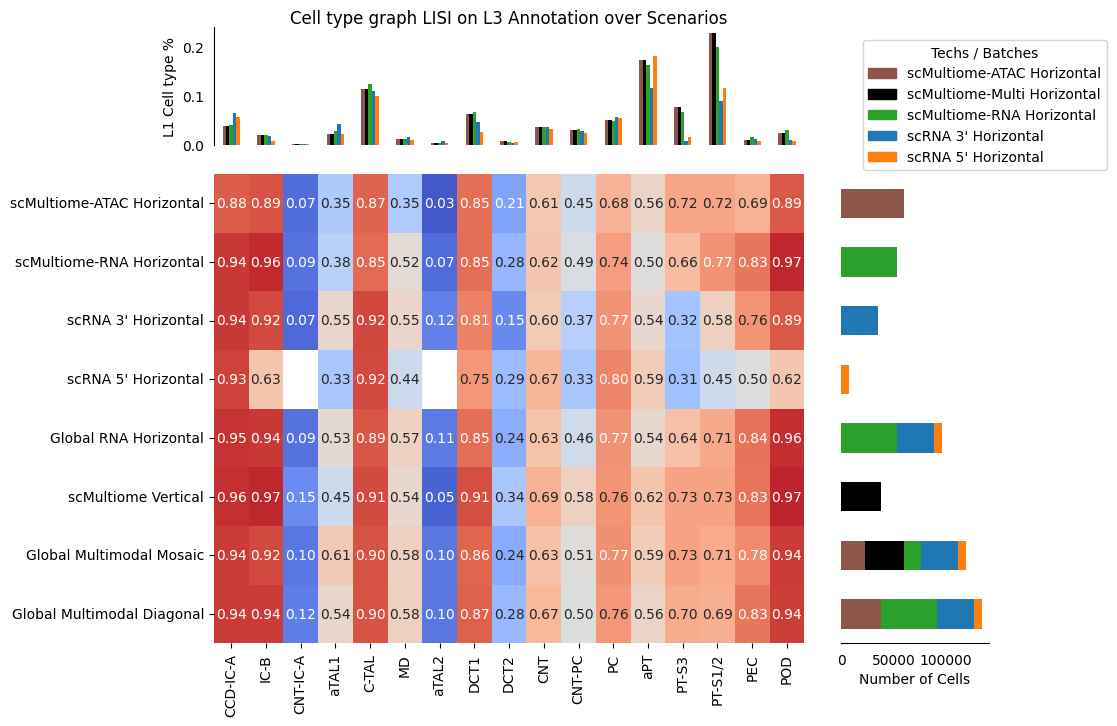

In [46]:
import matplotlib.lines as mlines

# for mod in mods:
rcParams['figure.figsize'] = (8,8)
cells = L3_cells_epi
metric_title = 'Cell type graph LISI'
# Setup
csv_folder = 'CLISI'
metric_name='binary_LISI'
save_name = 'L3_Epithelial'
vmin_heatmap = 0
min_pop_size = 40
ann_level = 'L3'

ann_l = ['Deepscore_HCA_l1_Clean', 'Deepscore_HCA_l3_Clean']

ann = ann_l[1]

shapes = ['o','s', '^', '*', 'D','d','P','1','2','3','4','8','p','+','x']  # Replace with your labels
mods = [ 'Spectral_Atac_mnn','snRNA', 'scRNA', 'scRNA5p', 'RNA_STWG_final', 'Spectral_Multi_mnn', 'MultiVI', 'GLUE']
obs_paths = ['atac','snRNA','scRNA',  'scRNA5p', 'RNA_Integration',  'Vertical', 'MultiVI', 'GLUE_comb']
names = [ 'scMultiome-ATAC Horizontal','scMultiome-RNA Horizontal',"scRNA 3' Horizontal",  "scRNA 5' Horizontal",  'Global RNA Horizontal',  'scMultiome Vertical', 'Global Multimodal Mosaic', 'Global Multimodal Diagonal']
mod_dict = {i:names[n] for n,i in enumerate(mods)}

color_dict = {
    'Global RNA Horizontal': '#d62728',
    "scRNA 3' Horizontal": '#1f77b4',
    "scRNA 5' Horizontal": '#ff7f0e',
    'scMultiome-RNA Horizontal': '#2ca02c',
    'scMultiome-ATAC Horizontal': '#8c564b', 
    'scMultiome-Multi Horizontal':'#000000',
    'scMultiome Vertical': '#9467bd',
    'Global Multimodal Mosaic': '#e377c2',
    'Global Multimodal Diagonal': '#17becf'
}

batch_maps = { 'snATAC':'scMultiome-ATAC Horizontal',
            'snMulti':'scMultiome-Multi Horizontal',
             'snRNA':'scMultiome-RNA Horizontal',
            'scRNA':"scRNA 3' Horizontal",
            'scRNA5p':"scRNA 5' Horizontal",
           }

# ann_l = ['Deepscore_HCA_l1_Clean']  # Assuming ann_l is a list of annotations
rcParams['figure.figsize'] = (8, 8)

# Initialize storage for results
results = {}
colors = [l1_colors, l3_colors]
# ann = ann_l[0]
df_averages = pd.DataFrame(index=cells, columns=names)
df_counts = pd.DataFrame(index=cells, columns=names)

obs = []
obs_top = []
# Loop over mods, obs_paths, and names
for mod, obs_path, name in zip(mods, obs_paths, names):
    # Read data
    adata_obs = pd.read_csv(f'obs/{obs_path}.csv', index_col=0)
    results[name] = {}

    if obs_path == 'GLUE_comb':
        
        adata_obs['modality'] = 'RNA'
        adata_obs['len_barcode'] = [len(i.split('-')) for i in adata_obs.index]
        adata_obs.loc[adata_obs[adata_obs['len_barcode'].isin([2])].index, 'modality'] = 'ATAC'

        adata_obs['Technology'] = [i.split('-')[-1] for i in adata_obs.index] 
        adata_obs.loc[adata_obs[adata_obs['len_barcode'].isin([2])].index, 'Technology'] = 'snATAC'
        adata_obs['Technology'].unique()
        adata_obs['batch'] = adata_obs['Technology'] 
    
    elif obs_path == 'atac':
        adata_obs['batch'] = 'snATAC'
        atac_barcodes = adata_obs.index
    elif obs_path == 'snRNA':
        atac_barcodes = adata_obs.index
    elif obs_path == 'Vertical':
        adata_obs['batch'] = 'snMulti'

    adata_obs['mod'] = mod
    if obs_path not in ['MultiVI', 'GLUE_comb']:
        obs_top.append(adata_obs)
    obs.append(adata_obs)
    # Loop over annotations and metrics
    for ann_path in [ann]:
        for metric in ['mean']:
            # Compute averages lists
            # averages_list1 = df_aver(adata_obs, ann, ann_path, mods=[mod], value_metric=metric)
            averages_list, counts_list = df_aver(adata_obs, ann, ann_path,name = metric_name, csv_folder=csv_folder, mods=[mod], value_metric=metric)
            # print(averages_list)
            # Extract values for each cell type
            for ct in cells:
                for col in averages_list.columns:
                    counts = counts_list.loc[ct, col]
                    # df_counts.at[ct, name] = counts

                    if averages_list.loc[ct, col] == 0:
                        continue
                    val = averages_list.loc[ct, col]
                    # val = (val+1)/2
                    df_averages.at[ct, name] = val
                    results[name][ct] = val
df_averages = df_averages.astype(float)
df_counts = pd.concat(obs, axis=0)
# df_counts = df_counts[df_counts[ann].isin(epi_cells)]

# plt.rcdefaults()
import matplotlib.patches as mpatches



import seaborn as sns
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], wspace=0.1, hspace=0.1)

# Heatmap
ax_heatmap = fig.add_subplot(gs[1, 0], anchor=(0,0))

sns.heatmap(df_averages.T, cmap='coolwarm', annot=True, ax=ax_heatmap, cbar=False, vmin = vmin_heatmap, vmax=1,fmt=".2f",annot_kws={"weight": "medium", "size":10})

# Top bar plot (number of cells per mod)




# Plotting
mod_counts = df_counts.groupby(['mod','batch']).size().unstack()

mod_counts = mod_counts[batch_maps.keys()]
modality_colors = [color_dict[batch_maps[mod]] for mod in mod_counts.columns]
mod_counts.index = [mod_dict[i] for i in mod_counts.index]
mod_counts = mod_counts.loc[df_averages.columns[::-1]]
# Right bar plot (number of cells per category)
ax_right_bar = fig.add_subplot(gs[1, 1],anchor = (0,1))
mod_counts.plot(kind='barh', stacked=True, color=modality_colors, ax=ax_right_bar)
ax_right_bar.set_xlabel('Number of Cells')
ax_right_bar.set_ylabel('')
ax_right_bar.spines['top'].set_visible(False)
ax_right_bar.spines['right'].set_visible(False)
ax_right_bar.spines['left'].set_visible(False)
# ax_right_bar.spines['bottom'].set_visible(False)
# Remove unnecessary ticks


df_counts_top = pd.concat(obs_top, axis=0)
# df_counts_top = df_counts_top[df_counts_top[ann].isin(epi_cells)]
df_proportions = df_counts_top.groupby([ann, 'batch']).size().unstack()
df_proportions = df_proportions.loc[df_proportions.index[~(df_proportions.sum(axis=1)==0)]]
# Calculating the proportions of each cell type within each modality
df_proportions = df_proportions.div(df_proportions.sum(axis=0), axis=1)
df_proportions = df_proportions.loc[cells]
# Averaging the proportions across modalities for each cell type
# df_mean_proportions = df_proportions.mean(axis=1)*100
df_proportions = df_proportions[mod_counts.columns]
# mod_counts = mod_counts[]


ax_top_bar = fig.add_subplot(gs[0, 0], anchor = (1,0))
df_proportions.plot(kind='bar', color=modality_colors, ax=ax_top_bar)
ax_top_bar.set_ylabel('L1 Cell type %')
ax_top_bar.set_xlabel('')
ax_top_bar.spines['top'].set_visible(False)
ax_top_bar.spines['right'].set_visible(False)
# ax_top_bar.spines['left'].set_visible(False)
ax_top_bar.spines['bottom'].set_visible(False)
ax_top_bar.tick_params(bottom=False, labelbottom=False)  # Remove x-axis labels






ax_top_bar.tick_params(left=False, bottom=False)
ax_right_bar.tick_params(left=False, bottom=False)
ax_right_bar.tick_params(left=False, labelleft=False)  # Remove y-axis labels

# modality_colors = {mod:color_dict[batch_maps[mod]] for mod in mod_counts.columns}

# cell_type_handles = [mpatches.Patch(color=l1_colors[name], label=name) for name in df_mean_proportions.index]
modality_handles = [mpatches.Patch(color=color_dict[batch_maps[mod]], label=batch_maps[mod]) for mod in mod_counts.columns]

ax_top_bar.legend([], [], frameon=False)
ax_right_bar.legend(handles=modality_handles, bbox_to_anchor=(0.1, 1.3), loc='upper left', title="Techs / Batches")

# Adjust layout
ax_top_bar.set_title(f'{metric_title} on {ann_level} Annotation over Scenarios', pad=3)
plt.tight_layout()
plt.savefig(f'figures/{csv_folder}_{save_name}.png', dpi = 300, bbox_inches='tight')
plt.savefig(f'figures/{csv_folder}_{save_name}.pdf', dpi = 300, bbox_inches='tight')

B in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
EC-LYM in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
MAST in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
N in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
NEU in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
NKC/T in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
PL in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
REN in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
aFIB in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
cDC in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
ncMON in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
pDC in Deepscore_HCA_l3_Clean_Spectral_Atac_mnn is too small
EC-LYM in Deepscore_HCA_l3_Clean_snRNA is too small
MAST in Deepscore_HCA_l3_Clean_snRNA is too small
N in Deepscore_HCA_l3_Clean_snRNA is too small
NEU in Deepscore_HCA_l3_Clean_snRNA is too small
PL in Deepscore_HCA_l3_Clean_snRNA is too small
REN in Deepscore_H

/tmp/ipykernel_11911/3070299775.py:57: DtypeWarning: Columns (10,20,21,23,24,25,29,33,35,42,43,54,55,56,57,58,59,62,66,67,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  adata_obs = pd.read_csv(f'obs/{obs_path}.csv', index_col=0)


MAST in Deepscore_HCA_l3_Clean_MultiVI is too small
NEU in Deepscore_HCA_l3_Clean_MultiVI is too small
pDC in Deepscore_HCA_l3_Clean_MultiVI is too small
MAST in Deepscore_HCA_l3_Clean_GLUE is too small
pDC in Deepscore_HCA_l3_Clean_GLUE is too small


/tmp/ipykernel_11911/3070299775.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_proportions = df_counts_top.groupby([ann, 'batch']).size().unstack()
/tmp/ipykernel_11911/3070299775.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


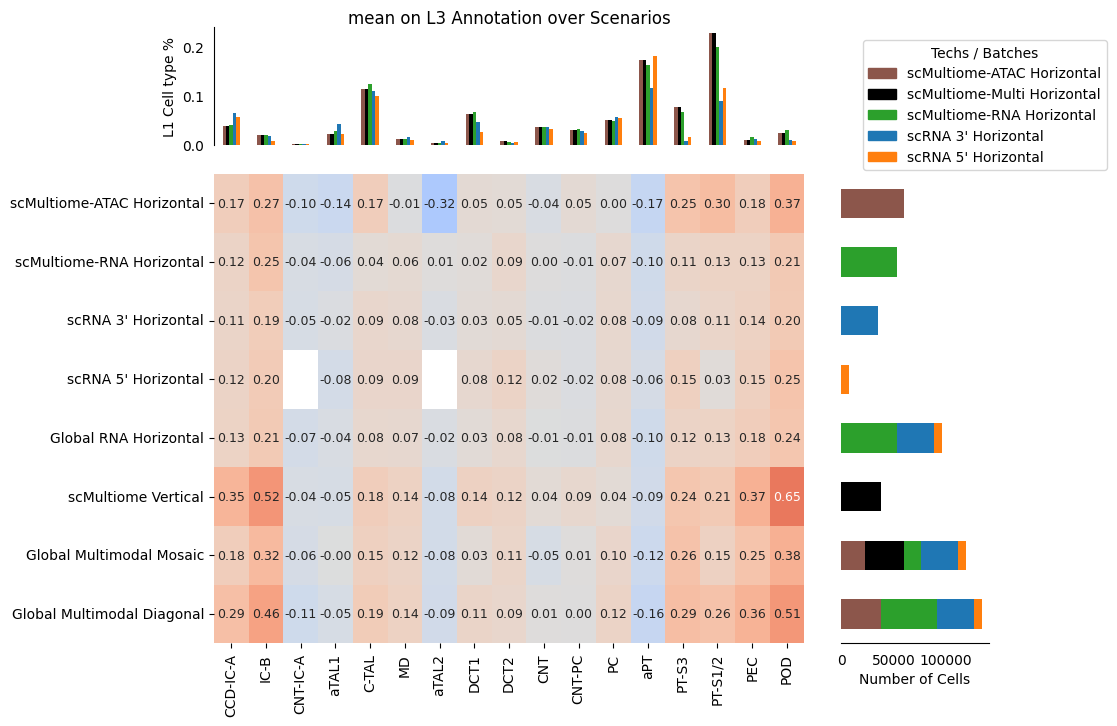

In [48]:
import matplotlib.lines as mlines

# for mod in mods:
rcParams['figure.figsize'] = (8,8)
cells = L3_cells_epi
metric = 'Latent Space Silhouette'
# Setup
csv_folder = 'Silhouette'
save_name = 'L3_Epithelial'

ann_level = 'L3'

ann_l = ['Deepscore_HCA_l1_Clean', 'Deepscore_HCA_l3_Clean']

ann = ann_l[1]

shapes = ['o','s', '^', '*', 'D','d','P','1','2','3','4','8','p','+','x']  # Replace with your labels
mods = [ 'Spectral_Atac_mnn','snRNA', 'scRNA', 'scRNA5p', 'RNA_STWG_final', 'Spectral_Multi_mnn', 'MultiVI', 'GLUE']
obs_paths = ['atac','snRNA','scRNA',  'scRNA5p', 'RNA_Integration',  'Vertical', 'MultiVI', 'GLUE_comb']
names = [ 'scMultiome-ATAC Horizontal','scMultiome-RNA Horizontal',"scRNA 3' Horizontal",  "scRNA 5' Horizontal",  'Global RNA Horizontal',  'scMultiome Vertical', 'Global Multimodal Mosaic', 'Global Multimodal Diagonal']
mod_dict = {i:names[n] for n,i in enumerate(mods)}

color_dict = {
    'Global RNA Horizontal': '#d62728',
    "scRNA 3' Horizontal": '#1f77b4',
    "scRNA 5' Horizontal": '#ff7f0e',
    'scMultiome-RNA Horizontal': '#2ca02c',
    'scMultiome-ATAC Horizontal': '#8c564b', 
    'scMultiome-Multi Horizontal':'#000000',
    'scMultiome Vertical': '#9467bd',
    'Global Multimodal Mosaic': '#e377c2',
    'Global Multimodal Diagonal': '#17becf'
}

batch_maps = { 'snATAC':'scMultiome-ATAC Horizontal',
            'snMulti':'scMultiome-Multi Horizontal',
             'snRNA':'scMultiome-RNA Horizontal',
            'scRNA':"scRNA 3' Horizontal",
            'scRNA5p':"scRNA 5' Horizontal",
           }

# ann_l = ['Deepscore_HCA_l1_Clean']  # Assuming ann_l is a list of annotations
rcParams['figure.figsize'] = (8, 8)

# Initialize storage for results
results = {}
colors = [l1_colors, l3_colors]
# ann = ann_l[0]
df_averages = pd.DataFrame(index=cells, columns=names)
df_counts = pd.DataFrame(index=cells, columns=names)

obs = []
obs_top = []
# Loop over mods, obs_paths, and names
for mod, obs_path, name in zip(mods, obs_paths, names):
    # Read data
    adata_obs = pd.read_csv(f'obs/{obs_path}.csv', index_col=0)
    results[name] = {}

    if obs_path == 'GLUE_comb':
        
        adata_obs['modality'] = 'RNA'
        adata_obs['len_barcode'] = [len(i.split('-')) for i in adata_obs.index]
        adata_obs.loc[adata_obs[adata_obs['len_barcode'].isin([2])].index, 'modality'] = 'ATAC'

        adata_obs['Technology'] = [i.split('-')[-1] for i in adata_obs.index] 
        adata_obs.loc[adata_obs[adata_obs['len_barcode'].isin([2])].index, 'Technology'] = 'snATAC'
        adata_obs['Technology'].unique()
        adata_obs['batch'] = adata_obs['Technology'] 
    
    elif obs_path == 'atac':
        adata_obs['batch'] = 'snATAC'
        atac_barcodes = adata_obs.index
    elif obs_path == 'snRNA':
        atac_barcodes = adata_obs.index
    elif obs_path == 'Vertical':
        adata_obs['batch'] = 'snMulti'

    adata_obs['mod'] = mod
    if obs_path not in ['MultiVI', 'GLUE_comb']:
        obs_top.append(adata_obs)
    obs.append(adata_obs)
    # Loop over annotations and metrics
    for ann_path in [ann]:
        for metric in ['mean']:
            # Compute averages lists
            # averages_list1 = df_aver(adata_obs, ann, ann_path, mods=[mod], value_metric=metric)
            averages_list, counts_list = df_aver(adata_obs, ann, ann_path,name = 'Silhouette', csv_folder=csv_folder, mods=[mod], value_metric=metric)
            # print(averages_list)
            # Extract values for each cell type
            for ct in cells:
                for col in averages_list.columns:
                    counts = counts_list.loc[ct, col]
                    # df_counts.at[ct, name] = counts

                    if averages_list.loc[ct, col] == 0:
                        continue
                    val = averages_list.loc[ct, col]
                    # val = (val+1)/2
                    df_averages.at[ct, name] = val
                    results[name][ct] = val
df_averages = df_averages.astype(float)
df_counts = pd.concat(obs, axis=0)
# df_counts = df_counts[df_counts[ann].isin(epi_cells)]

# plt.rcdefaults()
import matplotlib.patches as mpatches



import seaborn as sns
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], wspace=0.1, hspace=0.1)

# Heatmap
ax_heatmap = fig.add_subplot(gs[1, 0], anchor=(0,0))

sns.heatmap(df_averages.T, cmap='coolwarm', annot=True, ax=ax_heatmap, cbar=False, vmin = -1, vmax=1,fmt=".2f",annot_kws={"weight": "medium", "size":9})

# Top bar plot (number of cells per mod)




# Plotting
mod_counts = df_counts.groupby(['mod','batch']).size().unstack()

mod_counts = mod_counts[batch_maps.keys()]
modality_colors = [color_dict[batch_maps[mod]] for mod in mod_counts.columns]
mod_counts.index = [mod_dict[i] for i in mod_counts.index]
mod_counts = mod_counts.loc[df_averages.columns[::-1]]
# Right bar plot (number of cells per category)
ax_right_bar = fig.add_subplot(gs[1, 1],anchor = (0,1))
mod_counts.plot(kind='barh', stacked=True, color=modality_colors, ax=ax_right_bar)
ax_right_bar.set_xlabel('Number of Cells')
ax_right_bar.set_ylabel('')
ax_right_bar.spines['top'].set_visible(False)
ax_right_bar.spines['right'].set_visible(False)
ax_right_bar.spines['left'].set_visible(False)
# ax_right_bar.spines['bottom'].set_visible(False)
# Remove unnecessary ticks


df_counts_top = pd.concat(obs_top, axis=0)
# df_counts_top = df_counts_top[df_counts_top[ann].isin(epi_cells)]
df_proportions = df_counts_top.groupby([ann, 'batch']).size().unstack()
df_proportions = df_proportions.loc[df_proportions.index[~(df_proportions.sum(axis=1)==0)]]
# Calculating the proportions of each cell type within each modality
df_proportions = df_proportions.div(df_proportions.sum(axis=0), axis=1)
df_proportions = df_proportions.loc[cells]
# Averaging the proportions across modalities for each cell type
# df_mean_proportions = df_proportions.mean(axis=1)*100
df_proportions = df_proportions[mod_counts.columns]
# mod_counts = mod_counts[]


ax_top_bar = fig.add_subplot(gs[0, 0], anchor = (1,0))
df_proportions.plot(kind='bar', color=modality_colors, ax=ax_top_bar)
ax_top_bar.set_ylabel('L1 Cell type %')
ax_top_bar.set_xlabel('')
ax_top_bar.spines['top'].set_visible(False)
ax_top_bar.spines['right'].set_visible(False)
# ax_top_bar.spines['left'].set_visible(False)
ax_top_bar.spines['bottom'].set_visible(False)
ax_top_bar.tick_params(bottom=False, labelbottom=False)  # Remove x-axis labels






ax_top_bar.tick_params(left=False, bottom=False)
ax_right_bar.tick_params(left=False, bottom=False)
ax_right_bar.tick_params(left=False, labelleft=False)  # Remove y-axis labels

# modality_colors = {mod:color_dict[batch_maps[mod]] for mod in mod_counts.columns}

# cell_type_handles = [mpatches.Patch(color=l1_colors[name], label=name) for name in df_mean_proportions.index]
modality_handles = [mpatches.Patch(color=color_dict[batch_maps[mod]], label=batch_maps[mod]) for mod in mod_counts.columns]

ax_top_bar.legend([], [], frameon=False)
ax_right_bar.legend(handles=modality_handles, bbox_to_anchor=(0.1, 1.3), loc='upper left', title="Techs / Batches")

# Adjust layout
ax_top_bar.set_title(f'{metric} on {ann_level} Annotation over Scenarios', pad=3)
plt.tight_layout()
plt.savefig(f'figures/{csv_folder}_{save_name}.png', dpi = 300, bbox_inches='tight')
plt.savefig(f'figures/{csv_folder}_{save_name}.pdf', dpi = 300, bbox_inches='tight')